In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# For PLotting we will use these library

import matplotlib.pyplot as plt

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [2]:

# Step 1: Data cleaning
data = yf.download(tickers='ETH-usd', start='2017-11-09', end='2022-12-31', interval='1d')
#data = yf.download(tickers='ETH-USD', period='max', interval='1d')
data.dropna(inplace=True)
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...
2022-12-26,1218.920166,1226.974365,1214.335938,1226.974365,1226.974365,3282098400
2022-12-27,1226.987061,1230.418091,1205.895630,1212.791626,1212.791626,4091530737
2022-12-28,1212.736572,1213.128906,1185.702148,1189.986084,1189.986084,4991669631


In [3]:
# Step 2: Feature engineering
data['RSI']       = ta.rsi(data.Close, length=15)
data['EMA_short'] = ta.ema(data.Close, length=20)
data['EMA_long']  = ta.ema(data.Close, length=100)
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Close'], axis=1, inplace=True)
# Setting the index
data.set_index('Date', inplace=True)

# Dropping any NaNs
data.dropna(inplace=True)

data.info()
data.tail(10)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1779 entries, 2018-02-16 to 2022-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1779 non-null   float64
 1   High       1779 non-null   float64
 2   Low        1779 non-null   float64
 3   Adj Close  1779 non-null   float64
 4   Volume     1779 non-null   int64  
 5   RSI        1779 non-null   float64
 6   EMA_short  1779 non-null   float64
 7   EMA_long   1779 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 125.1 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2022-12-21,1217.586426,1218.192261,1206.440063,1213.599976,4217182733,46.360226,1234.022934,1347.684823
2022-12-22,1213.672607,1221.986816,1187.127808,1218.182129,5297471739,46.932819,1232.514286,1345.120413
2022-12-23,1218.079346,1226.998779,1215.994873,1220.159424,4835831923,47.193442,1231.337632,1342.645938
2022-12-24,1220.117920,1224.911621,1216.338745,1221.148560,2626153345,47.332079,1230.367245,1340.240050
2022-12-25,1221.171509,1223.517822,1203.719604,1218.962036,3942720070,47.039585,1229.281034,1337.838505
2022-12-26,1218.920166,1226.974365,1214.335938,1226.974365,3282098400,48.294081,1229.061351,1335.643175
2022-12-27,1226.987061,1230.418091,1205.895630,1212.791626,4091530737,46.217774,1227.511854,1333.210471
2022-12-28,1212.736572,1213.128906,1185.702148,1189.986084,4991669631,43.030513,1223.937971,1330.374345
2022-12-29,1190.010132,1204.141602,1188.360229,1201.595337,4132233940,45.095621,1221.810101,1327.824266


In [4]:
data= data.to_csv('ETH_case1.csv')

In [5]:
from datetime import datetime

def date_parser(date_str):
    date_obj = datetime.strptime(date_str, '%m/%d/%Y')
    return date_obj.strftime('%m-%d-%Y')


In [20]:
data_csv = pd.read_csv('ETH_case1.csv')
data_csv.dropna(inplace=True)
# Setting the index

data_csv.set_index('Date', inplace=True)
# Dropping any NaNs
data_csv.dropna(inplace=True)
data_csv.info()
data_csv.tail(10)

<class 'pandas.core.frame.DataFrame'>
Index: 1779 entries, 2018-02-16 to 2022-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1779 non-null   float64
 1   High       1779 non-null   float64
 2   Low        1779 non-null   float64
 3   Adj Close  1779 non-null   float64
 4   Volume     1779 non-null   int64  
 5   RSI        1779 non-null   float64
 6   EMA_short  1779 non-null   float64
 7   EMA_long   1779 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 125.1+ KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2022-12-21,1217.586426,1218.192261,1206.440063,1213.599976,4217182733,46.360226,1234.022934,1347.684823
2022-12-22,1213.672607,1221.986816,1187.127808,1218.182129,5297471739,46.932819,1232.514286,1345.120413
2022-12-23,1218.079346,1226.998779,1215.994873,1220.159424,4835831923,47.193442,1231.337632,1342.645938
2022-12-24,1220.117920,1224.911621,1216.338745,1221.148560,2626153345,47.332079,1230.367245,1340.240050
2022-12-25,1221.171509,1223.517822,1203.719604,1218.962036,3942720070,47.039585,1229.281034,1337.838505
2022-12-26,1218.920166,1226.974365,1214.335938,1226.974365,3282098400,48.294081,1229.061351,1335.643175
2022-12-27,1226.987061,1230.418091,1205.895630,1212.791626,4091530737,46.217774,1227.511854,1333.210471
2022-12-28,1212.736572,1213.128906,1185.702148,1189.986084,4991669631,43.030513,1223.937971,1330.374345
2022-12-29,1190.010132,1204.141602,1188.360229,1201.595337,4132233940,45.095621,1221.810101,1327.824266


In [21]:
# Split the data into training and test sets
train_df = data_csv[:int(len(data_csv)*0.8)]
test_df = data_csv[int(len(data_csv)*0.8):]
data_csv.shape


(1779, 8)

In [22]:
test_data =test_df.copy()

In [8]:
train_x = train_df.index
train_y = train_df['Adj Close']
test_x = test_df.index
test_y = test_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_x, y=train_y, name='train Data'))
fig.add_trace(go.Scatter(x=test_x, y=test_y, name='Test Data'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='Price over time'
)

fig.show()


In [9]:
print(train_df.info())
print(test_df.info())
print('test_data', test_data.shape)


<class 'pandas.core.frame.DataFrame'>
Index: 1423 entries, 2018-02-16 to 2022-01-08
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1423 non-null   float64
 1   High       1423 non-null   float64
 2   Low        1423 non-null   float64
 3   Adj Close  1423 non-null   float64
 4   Volume     1423 non-null   int64  
 5   RSI        1423 non-null   float64
 6   EMA_short  1423 non-null   float64
 7   EMA_long   1423 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 100.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 2022-01-09 to 2022-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       356 non-null    float64
 1   High       356 non-null    float64
 2   Low        356 non-null    float64
 3   Adj Close  356 non-null    float64
 4   Volume     356 non-null    int64  
 5   RSI        356 non-null   

In [10]:
# Preprocess the data
X_train = train_df.drop(['Adj Close'], axis=1).values
y_train = train_df['Adj Close'].values

X_test = test_df.drop(['Adj Close'], axis=1).values
y_test = test_df['Adj Close'].values

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


x_train (1423, 7)
y_train (1423,)
X_test (356, 7)
y_test (356,)


In [11]:
scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)
y_train = y_train.reshape(-1,1)
y_train = scaler.fit_transform(y_train)
y_test  = y_test.reshape(-1,1)
y_test  = scaler.fit_transform(y_test)
#------------------------------------------
print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape) 

x_train (1423, 7)
y_train (1423, 1)
X_test (356, 7)
y_test (356, 1)


In [12]:
# Step 5: Reshaping the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape)
print('X_train.shape[1]', X_train.shape[1])
print('X_train.shape[2]', X_train.shape[2])


X_train (1423, 1, 7)
y_train (1423, 1)
X_test (356, 1, 7)
Y_test (356, 1)
X_train.shape[1] 1
X_train.shape[2] 7


In [13]:
# Step 6: Building the LSTM model (cont.)

model = Sequential()
model.add(LSTM(100, input_shape=( X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(75, return_sequences=True, activation='tanh'))
model.add(Dropout(0.25))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['accuracy', 'mean_absolute_error'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            43200     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 75)             52800     
                                                                 
 dropout_2 (Dropout)         (None, 1, 75)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [14]:
# Step 7: Training and evaluating the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=32)


Epoch 1/1000
45/45 [==============================] - 31s 18ms/step - loss: 0.0606 - accuracy: 0.0014 - mean_absolute_error: 0.1631
Epoch 2/1000
45/45 [==============================] - 1s 25ms/step - loss: 0.0057 - accuracy: 0.0014 - mean_absolute_error: 0.0492
Epoch 3/1000
45/45 [==============================] - 1s 26ms/step - loss: 0.0039 - accuracy: 0.0014 - mean_absolute_error: 0.0360
Epoch 4/1000
45/45 [==============================] - 1s 22ms/step - loss: 0.0030 - accuracy: 0.0014 - mean_absolute_error: 0.0288
Epoch 5/1000
45/45 [==============================] - 1s 22ms/step - loss: 0.0021 - accuracy: 0.0014 - mean_absolute_error: 0.0239
Epoch 6/1000
45/45 [==============================] - 1s 23ms/step - loss: 0.0023 - accuracy: 0.0014 - mean_absolute_error: 0.0242
Epoch 7/1000
45/45 [==============================] - 1s 22ms/step - loss: 0.0024 - accuracy: 0.0014 - mean_absolute_error: 0.0245
Epoch 8/1000
45/45 [==============================] - 1s 24ms/step - loss: 0.0023 

In [15]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_mean_absolute_error'])
    plt.plot(history['mean_absolute_error'])
    plt.legend(['val_mean_absolute_error', 'mean_absolute_error'])
    plt.title('mean_absolute_error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


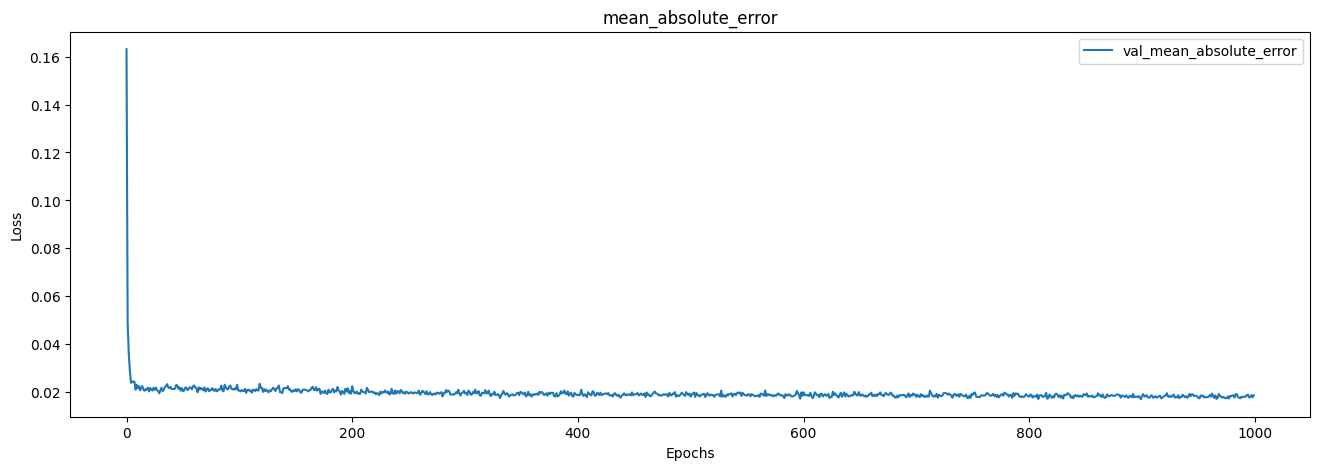

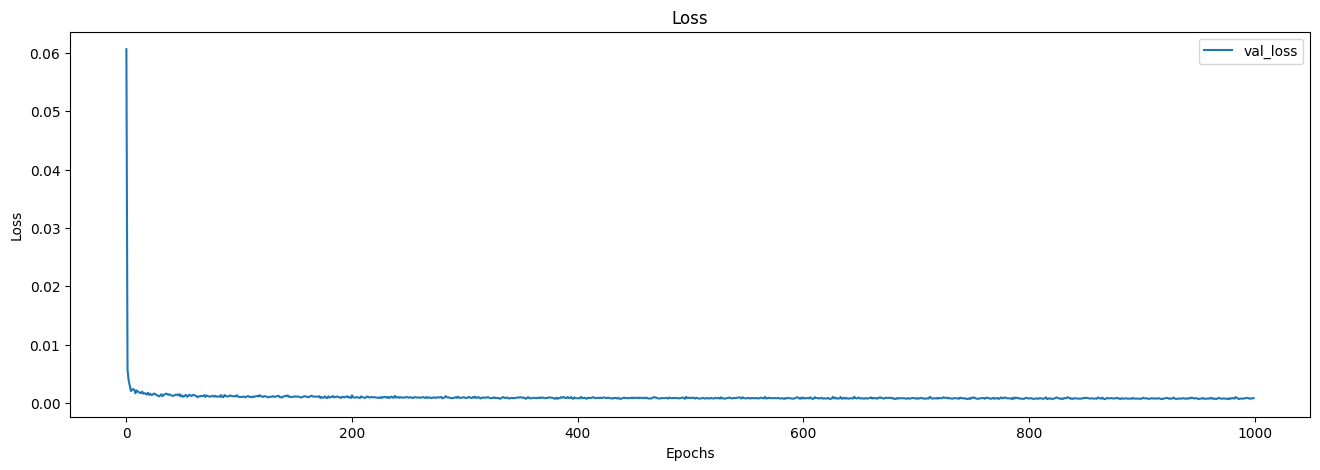

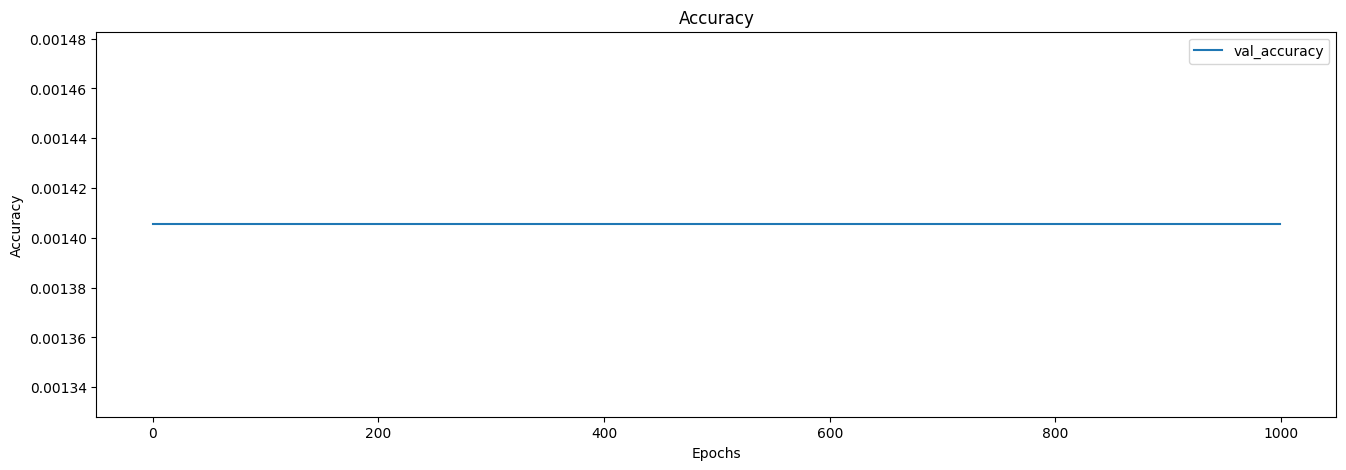

In [16]:
visualize_training_results(history)


In [17]:
# Evaluate the model on the test set
mse, accuracy, mae = model.evaluate(X_test, y_test)


12/12 [==============================] - 8s 7ms/step - loss: 7.8166e-04 - accuracy: 0.0056 - mean_absolute_error: 0.0238


In [18]:

# Step 8: Tuning the Hyperparameters
# You can use techniques such as grid search or random search to find the best values for the model's hyperparameters

# Step 9: Testing the model
y_pred = model.predict(X_test)
print('y_pred', y_pred.shape)
print('y_test', y_test.shape)




# evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))


12/12 [==============================] - 9s 7ms/step
y_pred (356, 1)
y_test (356, 1)
RMSE: 0.0280
MSE: 0.0008
MAE:0.0238


In [19]:

# convert to original data
y_pred = scaler.inverse_transform(y_pred)
y_test= scaler.inverse_transform(y_test)


# evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = 100 * np.mean(np.abs((y_test - y_pred) / y_test))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print("MAPE: {:.4f}%".format(mape))
print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))

MAPE: 3.3574%
RMSE: 70.7119
MSE: 5000.1674
MAE:60.1435


In [23]:
y_pred_df = pd.DataFrame(y_pred, columns=["Adj Close"])
y_test_df = pd.DataFrame(y_test, columns=["Adj Close"])

# Get the length of y_pred
y_pred_length = y_pred.shape[0]
y_test_length = y_test.shape[0]

# Generate dates for the next y_pred_length days ي
today = pd.Timestamp.now().date()
prediction_dates = today - timedelta(days=y_pred_length-1)
test = today - timedelta(days=y_test_length-1)
prediction = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')
test_dates = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')

# Use the generated dates as the index of the DataFrame
y_pred_df['Date'] = prediction

y_test_df['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column
y_pred_df.set_index('Date', inplace=True)
y_test_df.set_index('Date', inplace=True)


# Assuming y_pred is a numpy array




In [24]:

#y_test_df.to_csv("y_test_2021_2022.csv")
y_test_df

,Adj Close
Date,
2022-01-09,3157.751465
2022-01-10,3083.097900
2022-01-11,3238.111572
2022-01-12,3372.258301
2022-01-13,3248.288574
...,...
2022-12-26,1226.974365
2022-12-27,1212.791626
2022-12-28,1189.986084


In [25]:
#y_pred_df.to_csv("y_pred_2021_2022.csv")  # index=False to exclude index column in CSV
y_pred_df


,Adj Close
Date,
2022-01-09,3041.959961
2022-01-10,2939.619629
2022-01-11,3094.066406
2022-01-12,3227.740723
2022-01-13,3164.570312
...,...
2022-12-26,1142.325439
2022-12-27,1136.093384
2022-12-28,1120.769409


In [26]:

names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [27]:
# Calculate mean absolute percentage error (MAPE)
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))


mape_value = mape(y_test, y_pred)
print(f'MAPE: {mape_value:.4f}%')


MAPE: 3.3574%


In [28]:
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


SMAPE1 = smape(y_test, y_pred)
print("smape: {:.4f}%".format(SMAPE1))


smape: 3.4057%


In [29]:

# Step 1: Data cleaning

data_new = yf.download(tickers='ETH-USD', period='max', interval='1d')
data_new.dropna(inplace=True)
data_new


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...
2023-03-07,1567.424683,1579.162231,1543.127563,1561.933105,1561.933105,6854058349
2023-03-08,1561.977905,1568.175293,1534.088257,1534.088257,1534.088257,7130327525
2023-03-09,1534.031616,1544.108398,1423.264771,1438.660767,1438.660767,9457897583


In [30]:
# Step 2: Feature engineering
data_new['RSI']       = ta.rsi(data_new.Close, length=15)
data_new['EMA_short'] = ta.ema(data_new.Close, length=20)
data_new['EMA_long']  = ta.ema(data_new.Close, length=100)
data_new.dropna(inplace=True)
data_new.reset_index(inplace=True)
data_new.drop(['Close'], axis=1, inplace=True)
# Setting the index
data_new.set_index('Date', inplace=True)

# Dropping any NaNs
data_new.dropna(inplace=True)

data_new.info()
data_new.tail(10)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1850 entries, 2018-02-16 to 2023-03-11
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1850 non-null   float64
 1   High       1850 non-null   float64
 2   Low        1850 non-null   float64
 3   Adj Close  1850 non-null   float64
 4   Volume     1850 non-null   int64  
 5   RSI        1850 non-null   float64
 6   EMA_short  1850 non-null   float64
 7   EMA_long   1850 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 130.1 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2023-03-02,1663.549072,1672.051147,1622.599976,1647.319336,7080950926,53.607628,1629.743259,1503.225183
2023-03-03,1647.557739,1648.475342,1552.451538,1569.167603,9922240199,45.497589,1623.974149,1504.530974
2023-03-04,1569.278076,1575.637207,1551.736816,1566.923950,4389045367,45.286848,1618.540796,1505.766478
2023-03-05,1567.179321,1584.208862,1559.954102,1564.468750,5020886238,45.042238,1613.391078,1506.928900
2023-03-06,1564.383179,1579.456299,1557.363525,1567.398682,5245153345,45.419181,1609.010849,1508.126321
2023-03-07,1567.424683,1579.162231,1543.127563,1561.933105,6854058349,44.804974,1604.527255,1509.191802
2023-03-08,1561.977905,1568.175293,1534.088257,1534.088257,7130327525,41.725016,1597.818779,1509.684801
2023-03-09,1534.031616,1544.108398,1423.264771,1438.660767,9457897583,33.315721,1582.660873,1508.278384
2023-03-10,1438.760132,1438.760132,1378.525391,1429.158081,12665194936,32.614413,1568.041559,1506.711646


In [31]:
future_data = data_new.iloc[-30:, :]
future_data = future_data.values
future_data = pd.DataFrame(future_data, columns=["Open", "High", "Low", "Adj Close", "Volume", "RSI",
                                                 "EMA_short", "EMA_long"])

# Get the length of future_data
future_length = future_data.shape[0]

# Generate dates for the next 30 days
today = pd.Timestamp.now().date()
future_dates = today + timedelta(days=1)

future = pd.date_range(start=future_dates, end=today +
                       timedelta(days=30), freq='D')

# Generate dates for the next 10 days for predict
today = pd.Timestamp.now().date()
future_dates_pred = pd.date_range(start=today, periods=10, freq='D')

# Use the generated dates as the index of the DataFrame
future_data['Date'] = future

# Set the index of the dataframes to be the 'Date' column
future_data.set_index('Date', inplace=True)

future_data.tail(10)
x_future_data = future_data.drop(['Adj Close'], axis=1).values
y_future_data = future_data['Adj Close'].values
y_future_data = y_future_data.reshape(-1, 1)

print("x_future_data:", x_future_data.shape)
print("y_future_data:", y_future_data.shape)

# x_future_data= np.reshape(x_future_data, (x_future_data.shape[0], 1, x_future_data.shape[1]))

print("x_future_data:", x_future_data.shape)
x_future_data = scaler.fit_transform(x_future_data)
y_future_data = scaler.fit_transform(y_future_data)
for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]
    # future_data_temp = future_data_temp.reshape(-1, 1)
    print("future_data_temp", future_data_temp.shape)


x_future_data: (30, 7)
y_future_data: (30, 1)
x_future_data: (30, 7)
future_data_temp (30, 7)
future_data_temp (29, 7)
future_data_temp (28, 7)
future_data_temp (27, 7)
future_data_temp (26, 7)
future_data_temp (25, 7)
future_data_temp (24, 7)
future_data_temp (23, 7)
future_data_temp (22, 7)
future_data_temp (21, 7)


In [32]:

# Initialize a numpy array to store the predictions
prediction = np.zeros((10, 1))

for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]

    print("future_data_temp1", future_data_temp.shape)
    future_data_temp = np.reshape(future_data_temp, (future_data_temp.shape[0],
                                                     1, future_data_temp.shape[1]))
    pred = model.predict(future_data_temp)
    print("future_data_temp2", future_data_temp.shape)
    print('---------------------------------------------------')
    prediction[i][0] = pred[0][0]
    x_future_data[i+future_data_temp.shape[0]-1][0] = pred[0][0]
print('3', future_data.shape)
print('prediction:', prediction.shape)
# Reverse the MinMaxScaler
y_future_data = y_future_data.reshape(-1, 1)
y_future_data = scaler.inverse_transform(y_future_data)
prediction = scaler.inverse_transform(prediction)

# Create a new dataframe with the predicted values and the dates as the index
prediction_df = pd.DataFrame(
    prediction, index=future_dates_pred, columns=['Adj Close'])
print('y_future_data', y_future_data.shape)
# Get the length of future_data

y_future_data = pd.DataFrame(y_future_data,  columns=['Adj Close'])

future_length = future_data.shape[0]
test = today - timedelta(days=future_length-1)
test_dates = pd.date_range(start=test, end=today, freq='D')
# Use the generated dates as the index of the DataFrame


y_future_data['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column

y_future_data.set_index('Date', inplace=True)


future_data_temp1 (30, 7)
1/1 [==============================] - 0s 99ms/step
future_data_temp2 (30, 1, 7)
---------------------------------------------------
future_data_temp1 (29, 7)
1/1 [==============================] - 0s 113ms/step
future_data_temp2 (29, 1, 7)
---------------------------------------------------
future_data_temp1 (28, 7)
1/1 [==============================] - 0s 72ms/step
future_data_temp2 (28, 1, 7)
---------------------------------------------------
future_data_temp1 (27, 7)
1/1 [==============================] - 0s 124ms/step
future_data_temp2 (27, 1, 7)
---------------------------------------------------
future_data_temp1 (26, 7)
1/1 [==============================] - 0s 108ms/step
future_data_temp2 (26, 1, 7)
---------------------------------------------------
future_data_temp1 (25, 7)
1/1 [==============================] - 0s 94ms/step
future_data_temp2 (25, 1, 7)
---------------------------------------------------
future_data_temp1 (24, 7)
1/1 [============

In [33]:
prediction_df


,Adj Close
2023-03-11,1530.771282
2023-03-12,1533.007924
2023-03-13,1515.747289
2023-03-14,1495.069923
2023-03-15,1524.600149
2023-03-16,1600.106083
2023-03-17,1629.600259
2023-03-18,1653.759869
2023-03-19,1668.005904
2023-03-20,1676.867991


In [34]:
y_future_data


,Adj Close
Date,
2023-02-10,1514.869141
2023-02-11,1539.926758
2023-02-12,1515.033691
2023-02-13,1507.165894
2023-02-14,1556.875122
2023-02-15,1673.745972
2023-02-16,1640.067627
2023-02-17,1694.783325
2023-02-18,1691.819458


In [36]:
names = cycle(['Predictions next 10 day', 'Actual data '])

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_future_data.index, y=y_future_data['Adj Close'], name='Actual data ',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='blue')))

fig.add_shape(type='line',
              x0=prediction_df.index[0], y0=prediction_df['Adj Close'][0],
              x1=y_future_data.index[-1], y1=y_future_data['Adj Close'][-1],
              line=dict(color='grey', width=2))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [37]:
actual_x = y_future_data.index
actual_y = y_future_data['Adj Close']
pred_x = prediction_df.index
pred_y = prediction_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=actual_x, y=actual_y, name='Actual Data'))
fig.add_trace(go.Scatter(x=pred_x, y=pred_y,
              name='Predictions Data for 10 day'))

fig.add_shape(type='line',
              x0=actual_x[-1], y0=actual_y[-1],
              x1=pred_x[0], y1=pred_y[0],
              line=dict(color='grey', width=2, dash='dot'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='predict next 10 day '
)

fig.show()


In [38]:
future_data_all = data_new.copy()

future_data_all = pd.DataFrame(future_data_all, index= future_data_all.index, 
                               columns=future_data_all.columns)

x_future_data_all = future_data_all.drop(['Adj Close'], axis=1).values
y_future_data_all = future_data_all['Adj Close'].values
y_future_data_all = y_future_data_all.reshape(-1, 1)

print("x_future_data:", x_future_data_all.shape)
print("y_future_data:", y_future_data_all.shape)


x_future_data: (1850, 7)
y_future_data: (1850, 1)


In [39]:
x_future_data_all = scaler.fit_transform(x_future_data_all)
y_future_data_all = scaler.fit_transform(y_future_data_all)

x_future_data_all = np.reshape(x_future_data_all, (x_future_data_all.shape[0], 1, x_future_data_all.shape[1]))

pred_future_all = model.predict(x_future_data_all)


58/58 [==============================] - 1s 8ms/step


In [40]:

y_future_data_all = scaler.inverse_transform(y_future_data_all)
pred_future_all = scaler.inverse_transform(pred_future_all)
y_future_all = pd.DataFrame(y_future_data_all, index= future_data_all.index,  columns=['Adj Close'])
pred_future_all_df = pd.DataFrame(pred_future_all, index= future_data_all.index,  columns=['Adj Close'])
print("pred_future_all:", pred_future_all.shape)
print("y_future_data:", y_future_data_all.shape)

pred_future_all: (1850, 1)
y_future_data: (1850, 1)


In [41]:
names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_future_all.index, y=pred_future_all_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_future_all.index, y=y_future_all['Adj Close'], name='Actual Data',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='gray')))
fig.add_shape(type='line',
              x0=prediction_df.index[0], y0=prediction_df['Adj Close'][0],
              x1=pred_future_all_df.index[-1], y1=pred_future_all_df['Adj Close'][-1],
              line=dict(color='grey', width=2))

fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()
